# Index theory

First read some libraries needed. Notice, the functions we defined for plotting phase diagrams last time.


In [81]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt 
import sympy as sp
from sympy import pprint
from IPython.display import display, Markdown, Latex

%matplotlib inline

The routines from the lectures.

In [44]:
def plot_flow(ax,rhs,xrange=[-2.5,2.5],yrange=[-2.5,2.5],xnum=100,ynum=100,nullclines=False):

    # Set up u,v space
    u = np.linspace(xrange[0], xrange[1], xnum)
    v = np.linspace(yrange[0], yrange[1], ynum)
    uu, vv = np.meshgrid(u, v)

# Compute derivatives
    u_vel = np.empty_like(uu)
    v_vel = np.empty_like(vv)
    for i in range(uu.shape[0]):
        for j in range(uu.shape[1]):
            u_vel[i,j], v_vel[i,j] = rhs(0,np.array([uu[i,j], vv[i,j]]))


# Make stream plot
    ax.streamplot(uu, vv, u_vel, v_vel,color='grey')
#Nullclines
    if nullclines: 
        ax.contour(uu, vv, u_vel, [0],colors=('r'))
        ax.contour(uu, vv, v_vel, [0],colors=('b'))

    return ax

# A function that plots a path 
# def plot_solution(ax,rhs,y0,t_end,t_dim=2000,color='green',init_pt=True,linewidth=2.5):

#     t = np.linspace(0, t_end, t_dim)
#     X = sc.integrate.solve_ivp(rhs,t_span=[t[0],t[-1]],y0=y0,t_eval=t)
#     x,y=X.y
#     t=X.t
#     ax.plot(x,y, color=color,linewidth=linewidth)
#     if (init_pt):
#         ax=plot_point(ax,y0,color=color)
#     return ax

def get_solution(rhs, y0, t_end, t_dim=2000):
    t = np.linspace(0, t_end, t_dim)
    sol = sc.integrate.solve_ivp(rhs, t_span=[t[0], t[-1]], y0=y0, t_eval=t)
    return sol

def plot_solution(ax, rhs, y0, t_end, t_dim=2000, color='green', init_pt=True, linewidth=2.5, linestyle='-'):
    sol = get_solution(rhs, y0, t_end, t_dim)
    x, y = sol.y
    ax.plot(x, y, color=color, linewidth=linewidth,linestyle=linestyle)
    if init_pt:
        ax = plot_point(ax, y0, color=color)
    return ax

def plot_point(ax, coord, color='black',markersize=20):
    """Add fixed points to plot."""
    x,y=coord
    ax.plot(x,y, '.', color='black', markerfacecolor=color, markersize=markersize)
    return ax


def jacobian(rhs, xy, eps=1e-8):
    """
    Compute the Jacobian matrix of a system of differential equations at a given point.
    Parameters:
    rhs (function): The right-hand side function of the differential equations. It should take two arguments: time (t) and state (xy).
    xy (array-like): The point (x, y) at which to evaluate the Jacobian.
    eps (float, optional): A small perturbation value for numerical differentiation. Default is 1e-8.
    Returns:
    numpy.ndarray: A 2x2 Jacobian matrix evaluated at the point (x, y).
    Note:
    This function uses finite differences to approximate the partial derivatives.

    WARNING: The code and comment are from Gemini, use at own risk. 
    """

    
    f0 = np.array(rhs(0, xy))
    jac = np.zeros((2, 2))
    
    for i in range(2):
        dxy = np.zeros(2)
        dxy[i] = eps
        f1 = np.array(rhs(0, xy + dxy))
        jac[:, i] = (f1 - f0) / eps
    
    return jac

def eigenvalues_eigenvectors(jac):
    """
    Calculate the eigenvalues and eigenvectors of a given Jacobian matrix.
    Parameters:
    jac (numpy.ndarray): A square matrix representing the Jacobian matrix.
    Returns:
    tuple: A tuple containing two elements:
        - eigenvalues (numpy.ndarray): An array of eigenvalues.
        - eigenvectors (numpy.ndarray): An array of eigenvectors, where each column is an eigenvector corresponding to the eigenvalue at the same index.


    WARNING: The code and comment are from Gemini, use at own risk. 
    """

    eigenvalues, eigenvectors = np.linalg.eig(jac)
    return eigenvalues, eigenvectors





def plot_jordan(ax,rhs,r0=[0,0],rr=1,num=25,vectors=True, color='blue',linewidth=1.5):
    theta=np.linspace(0,2*np.pi, num)
    x=rr*np.cos(theta)+r0[0]
    y=rr*np.sin(theta)+r0[1]
    ax.plot(x,y,linewidth=linewidth, color=color)
    if vectors:
        U,V=rhs(0,[x,y])
        ax.quiver(x,y,U,V)

    return ax

    
def plot_vectors_along_line(ax, rhs, start_point, angle, length, num_vectors=10, color='red', plot_line=True):
    """
    Plot vectors defined by the rhs function along a line on the given axes.
            
    Parameters:
    ax (matplotlib.axes._axes.Axes): The axes on which to plot the vectors.
    rhs (function): The right-hand side function defining the vector field.
    start_point (tuple): The starting point of the line (x, y).
    angle (float): The angle of the line in radians.
    length (float): The length of the line.
    num_vectors (int, optional): The number of vectors to plot along the line. Default is 10.
    color (str, optional): The color of the vectors. Default is 'red'.
            
    Returns:
    matplotlib.axes._axes.Axes: The axes with the plotted vectors.
    """
    x0, y0 = start_point
    x_end = x0 + length * np.cos(angle)
    y_end = y0 + length * np.sin(angle)
    if plot_line:
        ax.plot([x0, x_end], [y0, y_end], color=color)
    for i in range(num_vectors):
        t = i / (num_vectors - 1)
        x = x0 + t * length * np.cos(angle)
        y = y0 + t * length * np.sin(angle)
        u, v = rhs(0, np.array([x, y]))
        ax.quiver(x, y, u, v, color=color)
    return ax

def winding_number(rhs, r0, rr, num=1000):
    theta = np.linspace(0, 2 * np.pi, num)
    x = rr * np.cos(theta) + r0[0]
    y = rr * np.sin(theta) + r0[1]
    
    F,G=rhs(0,[x,y])
    angles = np.arctan2(G, F)
    integrated_angle = np.sum(np.diff(np.unwrap(angles)))
    
    return integrated_angle / (2 * np.pi)



## Exercise 1
$$
\begin{array}{rl}
 \dot{x} = & - y + a x (x^2 + y^2)\\[0.5pt]
 \dot{y} = & x + a y (x^2+y^2)
\end{array}
$$


In [85]:
x, y = sp.symbols('x y')
a=sp.symbols('a',real=True)
dx=-y+a*x*(x**2+y**2)
dy=x+a*y*(x**2+y**2)
r, theta = sp.symbols('r theta')
dx_polar = dx.subs({x: r*sp.cos(theta), y: r*sp.sin(theta)})
dy_polar = dy.subs({x: r*sp.cos(theta), y: r*sp.sin(theta)})

dr = sp.simplify(dx_polar * sp.cos(theta) + dy_polar * sp.sin(theta))
dtheta = sp.simplify((dy_polar * sp.cos(theta) - dx_polar * sp.sin(theta)) / r)

dr_latex = sp.latex(dr)
dtheta_latex = sp.latex(dtheta)

display(Markdown("The equations in polar coordinates are:"))
display(Markdown(f"$$\\dot{{r}} = {dr_latex}$$"))
display(Markdown(f"$$\\dot{{\\theta}} = {dtheta_latex}$$"))


The equations in polar coordinates are:

$$\dot{r} = a r^{3}$$

$$\dot{\theta} = 1$$



### Phase portrait

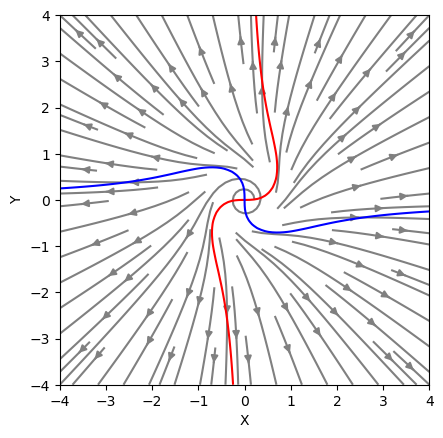

In [87]:
a=1
def rhs(t,xy,a=1):
    x,y=xy
    dx=- y + a * x*(x**2+y**2)
    dy=x + a * y*(x**2+y**2)
    return [dx,dy]


 # the coordinates for the centre of the circle


fig, ax = plt.subplots(1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')

ax=plot_flow(ax,rhs,xrange=[-4,4],yrange=[-4,4],nullclines=True)





## Exercise 2
$$
\begin{array}{rl}
 x'(t) = & - y +  x \sin(x^2 + y^2)\\[0.5pt]
 y'(t) = & x +  y\sin (x^2+y^2)
\end{array}
$$

In [88]:


dx=-y+a*x*sp.sin(x**2+y**2)
dy=x+a*y*sp.sin(x**2+y**2)
dx_polar = dx.subs({x: r*sp.cos(theta), y: r*sp.sin(theta)})
dy_polar = dy.subs({x: r*sp.cos(theta), y: r*sp.sin(theta)})

dr = sp.simplify(dx_polar * sp.cos(theta) + dy_polar * sp.sin(theta))
dtheta = sp.simplify((dy_polar * sp.cos(theta) - dx_polar * sp.sin(theta)) / r)

dr_latex = sp.latex(dr)
dtheta_latex = sp.latex(dtheta)

display(Markdown("The equations in polar coordinates are:"))
display(Markdown(f"$$\\dot{{r}} = {dr_latex}$$"))
display(Markdown(f"$$\\dot{{\\theta}} = {dtheta_latex}$$"))



The equations in polar coordinates are:

$$\dot{r} = r \sin{\left(r^{2} \right)}$$

$$\dot{\theta} = 1$$



### Phase portrait

<Axes: xlabel='X', ylabel='Y'>

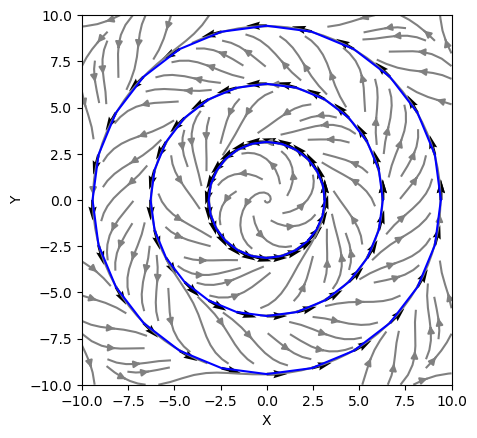

In [32]:
def rhs_2(t,xy,a=1):
    x,y=xy
    dx=- y +  x*np.sin(np.sqrt(x**2+y**2))
    dy=x +  y*np.sin(np.sqrt(x**2+y**2))
    return [dx,dy]


a=1  # the coordinates for the centre of the circle
rrange=10

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')

ax=plot_flow(ax,rhs_2,xrange=[-rrange,rrange],yrange=[-rrange,rrange],nullclines=False)

plot_jordan(ax,rhs_2,r0=[0,0],rr=np.pi,num=25,vectors=True, color='blue',linewidth=1.5)
plot_jordan(ax,rhs_2,r0=[0,0],rr=2*np.pi,num=25,vectors=True, color='blue',linewidth=1.5)
plot_jordan(ax,rhs_2,r0=[0,0],rr=3*np.pi,num=25,vectors=True, color='blue',linewidth=1.5)



## Exercise 5
$$
\begin{array}{rl}
 \dot{r} = & r(1-r^2)+ \mu r \cos(\theta)\\[0.5pt]
 \dot{\theta} = & 1
\end{array}
$$

/var/folders/mt/6thqwmbj5lvfz_9z7jnfcxt80000gn/T/ipykernel_62566/384101957.py:28: RuntimeWarning: invalid value encountered in sqrt
  plot_jordan(ax,rhs_5,r0=[0,0],rr=0.99*np.sqrt(1-mu),num=25,vectors=True, color='blue',linewidth=1.5)


<Axes: xlabel='X', ylabel='Y'>

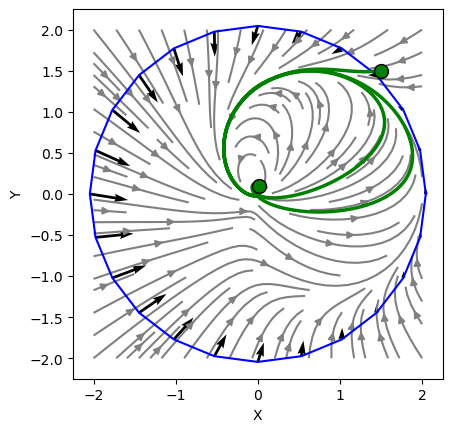

In [114]:
def rhs_5_polar(t,rtheta,mu=1):
    r,theta=rtheta
    dr= r*(1-r**2)+mu*r*np.cos(theta)
    dtheta= 1
    return [dr,dtheta]

mu=3.1

def rhs_5(t,xy):
    x,y=xy
    r=np.sqrt(x**2+y**2)
    theta=np.arctan2(y,x)
    dr, dtheta=rhs_5_polar(t,[r,theta],mu)
    dx=dr*np.cos(theta)-r*np.sin(theta)*dtheta
    dy=dr*np.sin(theta)+r*np.cos(theta)*dtheta
    return [dx,dy]

  # the coordinates for the centre of the circle
rrange=2

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')

ax=plot_flow(ax,rhs_5,xrange=[-rrange,rrange],yrange=[-rrange,rrange],nullclines=False)

plot_jordan(ax,rhs_5,r0=[0,0],rr=0.99*np.sqrt(1-mu),num=25,vectors=True, color='blue',linewidth=1.5)
plot_jordan(ax,rhs_5,r0=[0,0],rr=1.01*np.sqrt(1+mu),num=25,vectors=True, color='blue',linewidth=1.5)
plot_solution(ax,rhs_5,[0.01,0.1],t_end=10,color='green',init_pt=True,linewidth=2.5)
plot_solution(ax,rhs_5,[1.5,1.5],t_end=10,color='green',init_pt=True,linewidth=2.5)

#plot_jordan(ax,rhs_2,r0=[0,0],rr=2*np.pi,num=25,vectors=True, color='blue',linewidth=1.5)
#plot_jordan(ax,rhs_2,r0=[0,0],rr=3*np.pi,num=25,vectors=True, color='blue',linewidth=1.5)



## Exercise 6
$$
\begin{array}{rl}
 \dot{x} = & -a x + y\\[0.5pt]
 \dot{y} = & \frac{x^2}{1+x^2}- y
\end{array}
$$

In [80]:
a=sp.symbols('a',real=True)
x,y = sp.symbols('x y')
dx=-a*x+y
dy=x**2/(1+x**2)-y
rhs_sp = [dx, dy]
equilibrium_points = sp.solve([dx, dy], (x, y))
equilibrium_points = [sp.simplify(point) for point in equilibrium_points]
print("Equilibrium points:", equilibrium_points)

jac = sp.Matrix(rhs_sp).jacobian([x, y])
print("Jacobian matrix:")
print(jac)

for eq_point in equilibrium_points:
    jac_at_eq = jac.subs({x: eq_point[0], y: eq_point[1]})
    char_poly = jac_at_eq.charpoly()
    print(f"Characteristic polynomial at equilibrium point {eq_point}:")
    char_poly = sp.simplify(char_poly)
    pprint(char_poly)




Equilibrium points: [(0, 0), ((1 - sqrt(1 - 4*a**2))/(2*a), 1/2 - sqrt(1 - 4*a**2)/2), ((sqrt(1 - 4*a**2) + 1)/(2*a), sqrt(1 - 4*a**2)/2 + 1/2)]
Jacobian matrix:
Matrix([[-a, 1], [-2*x**3/(x**2 + 1)**2 + 2*x/(x**2 + 1), -1]])
Characteristic polynomial at equilibrium point (0, 0):
PurePoly(lambda**2 + (a + 1)*lambda + a, lambda, domain='ZZ[a]')
Characteristic polynomial at equilibrium point ((1 - sqrt(1 - 4*a**2))/(2*a), 1/2 - sqrt(1 - 4*a**2)/2):
PurePoly(lambda**2 + (a + 1)*lambda - 2*a**3*sqrt(1 - 4*a**2)/(2*a**2 + sqrt(1 ↪

↪  - 4*a**2) - 1) + 4*a**3/(2*a**2 + sqrt(1 - 4*a**2) - 1) + a*sqrt(1 - 4*a**2 ↪

↪ )/(2*a**2 + sqrt(1 - 4*a**2) - 1) - a/(2*a**2 + sqrt(1 - 4*a**2) - 1), lambd ↪

↪ a, domain='EX')
Characteristic polynomial at equilibrium point ((sqrt(1 - 4*a**2) + 1)/(2*a), sqrt(1 - 4*a**2)/2 + 1/2):
PurePoly(lambda**2 + (a + 1)*lambda + 2*a**3*sqrt(1 - 4*a**2)/(2*a**2 - sqrt(1 ↪

↪  - 4*a**2) - 1) + 4*a**3/(2*a**2 - sqrt(1 - 4*a**2) - 1) - a*sqrt(1 - 4*a**2 ↪

↪ )/(2*a**2 - sq


The equilibrium points are:
$$
\left(0, 0\right), \left(\frac{1 - \sqrt{1 - 4a^2}}{2a}, \frac{1}{2} - \frac{\sqrt{1 - 4a^2}}{2}\right), \left(\frac{\sqrt{1 - 4a^2} + 1}{2a}, \frac{\sqrt{1 - 4a^2}}{2} + \frac{1}{2}\right)
$$

### Phase portrait

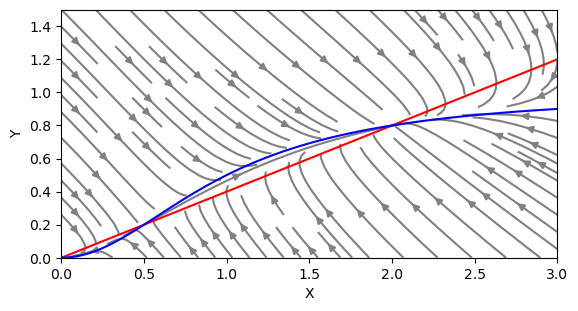

In [66]:

a=0.4
b=1
def rhs_6(t,xy):
    x,y=xy
    dx= - a*x+y
    dy= x**2/(b+x**2)-y
    return [dx,dy]

rrange=3

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')

ax=plot_flow(ax,rhs_6,xrange=[0,rrange],yrange=[0,1.5],nullclines=True)




In [175]:
from scipy.optimize import fsolve

def equations(vars):
    x, y = vars
    dx = - a * x + y
    dy = x**2 / (b + x**2) - y
    return [dx, dy]

# Initial guess for the roots
rt=np.sqrt(1-4*a**2)
x1=(1+rt)/(2*a)
x2=(1-rt)/(2*a)
initial_guess = [[0, 0],[x1,-a*x1],[x2,-a*x2]]

# Find the roots
roots = [fsolve(equations, guess) for guess in initial_guess]

print("Roots of rhs_6:", roots)

Roots of rhs_6: [array([0., 0.]), array([2. , 0.8]), array([0.5, 0.2])]


Root: [0. 0.]
Eigenvalues of root: [-0.39999998 -1.00000002]
Eigenvectors of root: [[ 1.00000000e+00 -8.57492919e-01]
 [ 1.66666662e-08  5.14495766e-01]]
Root: [2.  0.8]
Eigenvalues of root: [-0.2        -1.20000001]
Eigenvectors of root: [[ 0.98058068 -0.78086881]
 [ 0.19611614  0.62469505]]
Root: [0.5 0.2]
Eigenvalues of root: [ 0.15440037 -1.55440038]
Eigenvectors of root: [[ 0.87458584 -0.65475092]
 [ 0.48487072  0.75584471]]
Saddle point detected at root: [0.5 0.2]
start_point: [0.50087459 0.20048487]
start_point: [0.49912541 0.19951513]
start_point: [0.49934525 0.20075584]
start_point: [0.50065475 0.19924416]


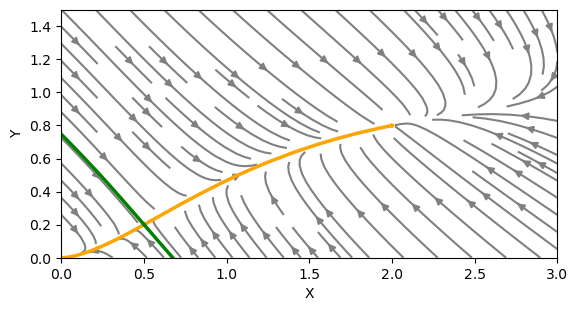

In [223]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')

ax=plot_flow(ax,rhs_6,xrange=[0,rrange],yrange=[0,1.5],nullclines=False)

for root in roots:
    jac=jacobian(rhs_6,root)
    vals,vecs=eigenvalues_eigenvectors(jac)
    print("Root:",root)
    print("Eigenvalues of root:",vals)
    print("Eigenvectors of root:",vecs)
    if np.any(np.real(vals) > 0) and np.any(np.real(vals) < 0):
        print("Saddle point detected at root:", root)
        for i, val in enumerate(vals):
            if np.real(val) < 0:
                direction = vecs[:, i]
                start_point = root + 0.001 * direction
                print("start_point:",start_point)
                plot_solution(ax, rhs_6, y0=start_point, t_end=-15, color='green', init_pt=False, linewidth=2.5)
                
                start_point = root - 0.001 * direction
                print("start_point:",start_point)

                plot_solution(ax, rhs_6, y0=start_point, t_end=-25, color='green', init_pt=False, linewidth=2.5)
            if np.real(val) > 0:
                direction = vecs[:, i]
                start_point = root + 0.001 * direction
                print("start_point:",start_point)
                plot_solution(ax, rhs_6, y0=start_point, t_end=235, color='orange', init_pt=False, linewidth=2.5)
                
                start_point = root - 0.001 * direction
                print("start_point:",start_point)

                plot_solution(ax, rhs_6, y0=start_point, t_end=225, color='orange', init_pt=False, linewidth=2.5)
  
ax.set_xlim([0, rrange])
ax.set_ylim([0, 1.5])

plt.show()
 

## Exercise 7
$$
\begin{array}{rl}
 \dot{x} = & - x + a y + x^2 y\\[0.5pt]
 \dot{y} = & b −a y−x^2 y
\end{array}
$$

0.0574794331177344


(0.0, 3.546511627906977)

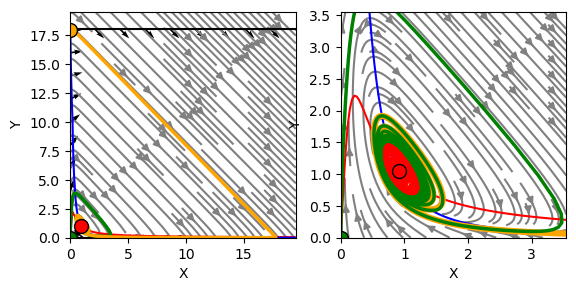

In [13]:

a=0.05
b=0.9

print(-b**2- 0.5+ 0.5*np.sqrt(8*b**2+1))
def rhs_7(t,xy):
    x,y=xy
    dx= - x+a*y+x**2*y
    dy= b - a*y- x**2*y
    return [dx,dy]

rrange=3

fig, axs = plt.subplots(1, 2)
ax=axs[0]
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')
rrange=b/a+1.5
plot_flow(ax,rhs_7,xrange=[0,rrange],yrange=[0,rrange],nullclines=True)
plot_vectors_along_line(ax, rhs_7, start_point=[0,0], angle=0, length=10, num_vectors=10, color='black')
plot_vectors_along_line(ax, rhs_7, start_point=[0,b/a+0.01], angle=0, length=rrange, num_vectors=10, color='black')
plot_vectors_along_line(ax, rhs_7, start_point=[0,0], angle=np.pi/2, length=b/a, num_vectors=10, color='black')
plot_solution(ax,rhs_7,[0,0],t_end=100,color='green',init_pt=True,linewidth=2.5)
plot_solution(ax,rhs_7,[0,b/a],t_end=100,color='orange',init_pt=True,linewidth=2.5)
plot_solution(ax,rhs_7,[b+0.01,b/(b**2+a)],t_end=100,color='red',init_pt=True,linewidth=2.5)

ax=axs[1]
ax.set_xlabel('X')
ax.set_ylabel('Y')
rrange=np.max([b,b/(a+b**2)])+2.5
ax.set_aspect('equal')
plot_flow(ax,rhs_7,xrange=[0,rrange],yrange=[0,rrange],nullclines=True)
plot_solution(ax,rhs_7,[0,b/a],t_end=100,color='orange',init_pt=True,linewidth=4.5)
plot_solution(ax,rhs_7,[0,0],t_end=100,color='green',init_pt=True,linewidth=2.5)
plot_solution(ax,rhs_7,[b+0.01,b/(b**2+a)],t_end=200,color='red',init_pt=True,linewidth=1.5)

ax.set_xlim([0, rrange])
ax.set_ylim([0, rrange])

In [33]:
import sympy as sp
from sympy import pprint

x,y=sp.symbols('x y',real=True)
a,b=sp.symbols('a b',real=True,positive=True)
dx=- x+a*y+x**2*y
dy= b - a*y- x**2*y

equilibrium_points = sp.solve([dx, dy], (x, y))
print("Equilibrium points:", equilibrium_points)



Equilibrium points: [(b, b/(a + b**2))]


In [34]:
jac=sp.Matrix([dx,dy]).jacobian([x,y])
print("Jacobian matrix:")
jac

Jacobian matrix:


Matrix([
[2*x*y - 1,  a + x**2],
[   -2*x*y, -a - x**2]])

In [35]:
# Substitute equilibrium points into the Jacobian matrix
equilibrium_point = equilibrium_points[0]
jac_at_eq = jac.subs({x: equilibrium_point[0], y: equilibrium_point[1]})

# Find the characteristic polynomial
char_poly = jac_at_eq.charpoly()

print("Characteristic polynomial:")
print(char_poly)   

Characteristic polynomial:
PurePoly(lambda**2 + (a**2 + 2*a*b**2 + a + b**4 - b**2)/(a + b**2)*lambda + a + b**2, lambda, domain='ZZ(a,b)')


In [36]:
simple_char_poly = sp.simplify(char_poly)
simple_char_poly

PurePoly(lambda**2 + (a**2 + 2*a*b**2 + a + b**4 - b**2)/(a + b**2)*lambda + a + b**2, lambda, domain='ZZ(a,b)')

In [42]:
eigenvalues_at_eq = sp.solve(simple_char_poly, sp.symbols('lambda'))
print("Eigenvalues at equilibrium point:", eigenvalues_at_eq)
simplified_eigenvalues_at_eq = [sp.simplify(eigenvalue) for eigenvalue in eigenvalues_at_eq]
print(simplified_eigenvalues_at_eq)

Eigenvalues at equilibrium point: [(-a**2 - 2*a*b**2 - a - b**4 + b**2 - sqrt(a**4 + 4*a**3*b**2 - 2*a**3 + 6*a**2*b**4 - 10*a**2*b**2 + a**2 + 4*a*b**6 - 14*a*b**4 - 2*a*b**2 + b**8 - 6*b**6 + b**4))/(2*(a + b**2)), (-a**2 - 2*a*b**2 - a - b**4 + b**2 + sqrt(a**4 + 4*a**3*b**2 - 2*a**3 + 6*a**2*b**4 - 10*a**2*b**2 + a**2 + 4*a*b**6 - 14*a*b**4 - 2*a*b**2 + b**8 - 6*b**6 + b**4))/(2*(a + b**2))]
[(-a**2 - 2*a*b**2 - a - b**4 + b**2 - sqrt(a**4 + 4*a**3*b**2 - 2*a**3 + 6*a**2*b**4 - 10*a**2*b**2 + a**2 + 4*a*b**6 - 14*a*b**4 - 2*a*b**2 + b**8 - 6*b**6 + b**4))/(2*(a + b**2)), (-a**2 - 2*a*b**2 - a - b**4 + b**2 + sqrt(a**4 + 4*a**3*b**2 - 2*a**3 + 6*a**2*b**4 - 10*a**2*b**2 + a**2 + 4*a*b**6 - 14*a*b**4 - 2*a*b**2 + b**8 - 6*b**6 + b**4))/(2*(a + b**2))]
